In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
context_length = 4 #  how many characters do we take to predict the next one?

def build_dataset(words,context_length):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * context_length
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  # print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1],context_length)
Xdev, Ydev = build_dataset(words[n1:n2],context_length)
Xte, Yte = build_dataset(words[n2:],context_length)

In [5]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 4]), torch.Size([182625]))

In [6]:
dimR = 10
hl_size = 200
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, dimR), generator=g)
W1 = torch.randn((context_length*dimR, hl_size), generator=g)
b1 = torch.randn(hl_size, generator=g)
W2 = torch.randn((hl_size, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

13897

In [7]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [8]:
lri = []
lossi = []
stepi = []
bs = 32   
max_steps = 200000
for i in range(max_steps):
  
  # minibatch construct
                                                              #NOTE: training with batches drasticaly increses the training time~
  ix = torch.randint(0, Xtr.shape[0], (bs,))    #batch size = 32
  
  ## forward pass ##
  emb = C[Xtr[ix]] # (32, context_length, Rdim)                         #NOTE: Equiv to matrix mulit and one_hot encoding
  In = emb.view(-1, W1.shape[0])                                        #NOTE: using view over concatante as pytorch doenst need to make a new tensor. 
                                                                        #NOTE: when putting -1, it means that pytorch will infer what the correct value should be
  h = torch.tanh(In @ W1 + b1) # (32, hl_size)                          #NOTE: make sure you always check broadcasting rule, (will do below)
  logits = h @ W2 + b2 # (32, 27) 
  loss = F.cross_entropy(logits, Ytr[ix])                               
  
  
  ## backward pass ##
  for p in parameters:
    p.grad = None
  loss.backward()
  
  ## update ##
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  # lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  ## track stats ##
#   lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

print(loss.item())

2.05411958694458


Firstly it is important to check that boardcasting is doing what we expect. Lets first look at In @ W2 + b2, the left is a (32,hl_size) which in our case so far is 200, and b1 is (hl_size). Therefore alining from the right and adding a dimension where there isnt any gives,

(32,hl_size)
(1, hl_size)

which means that the broadcasting will consider b1 as a row, and copy vertical to make it (32,hl_size). Which is what we want, this case for the logits follows similarly.

Secondly we used F.cross_entropy instead of previously coding it ourselfs with:

    counts = logits.exp()                         # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

We do this for a few reasons, 
Firstly pytorch optemises the algorthim so it is quicker, and the backwards pass is much more effiect by taking into account what its derived derivative is (similar like to what we did to tanh in micrograd), another reason is that it elimates the worry of the exp being to large for our float point number which would give a value of inf, which is not what we want. It does this by using the fact that probs in the above code is dependent on just difference of the values, so it minus the largest values so that all values are less then or equal to 0, which leads exp of the values to be less then or equal to 1, and hence well behaved. 

e.g

In [9]:
#Problem case
example = torch.tensor([-2,-3,0,100])
example_counts = example.exp()
example_probs = example_counts / example_counts.sum()
print(f'{example_counts=}')
print(f'{example_probs=}')

example_counts=tensor([0.1353, 0.0498, 1.0000,    inf])
example_probs=tensor([0., 0., 0., nan])


In [10]:

example = torch.tensor([-2,-3,0,5])
example_counts = example.exp()
example_probs = example_counts / example_counts.sum()
print(f'{example_probs=}')

example_probs=tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])


In [11]:
example = torch.tensor([-2,-3,0,5]) - 5
example_counts = example.exp()
example_probs = example_counts / example_counts.sum()
print(f'{example_probs=}')

example_probs=tensor([9.0466e-04, 3.3281e-04, 6.6846e-03, 9.9208e-01])


Plot of the training step agains loss:

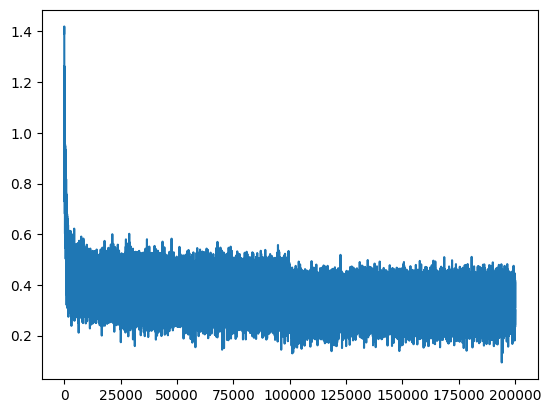

In [12]:
plt.plot(stepi, lossi)

The 'thickness' is becauses of the batches making noise, we could reduce the noice by increaseing the batch size: This is something that will be considered bellow. 

In [13]:
# evalutae the loss on the whole training set
emb = C[Xtr] # (32, 3, 2) = (batch_size,context_size,dimR)
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 200)  = (batch_size, hl_size)     
logits = h @ W2 + b2 # (32, 27) = (batch_size, len(char))
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1492, grad_fn=<NllLossBackward0>)

In [14]:
# evaluate the loss on the whole dev set
emb = C[Xdev] # (32, 3, 2) = (batch_size,context_size,dimR)
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 200) = (batch_size, hl_size)
logits = h @ W2 + b2 # (32, 27) = (batch_size, len(char))
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1843, grad_fn=<NllLossBackward0>)

we see the the training and the dev loss are similar so we are not overfitting, (this is cus are network is very small)

since we where under fitting we expec that making the hiden layer bigged to reduced the loss, if this is not the case means that we may have a bottle neck somewhere else, which would indicate a botle neck in the chioce of only 2 dimension 

before scaling up the dimension of the embeding lets think about how to visualise it. Note that after increase the dim past 3 we cant really visualise easily.

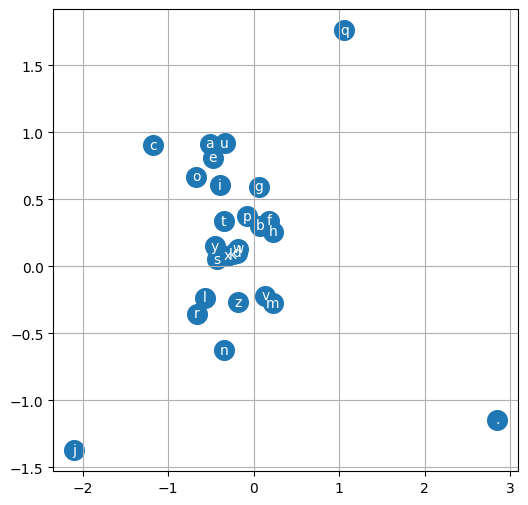

In [15]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters, not that this only gives a good picutre when are embedining into R^2
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')


Notice how the vows are slightly away from the main cluster, since the netword thinks of them as being similar. we can notice a little bit it of structer. 

what does the model look like so far:

In [16]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * context_length # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
nihlyal.
remyr.
jendra.
graderydoe.
ilen.
popelle.
elisan.
narleigh.
mhlara.
noshon.
roshirie.
trin.
renlyn.
jebeulan.
breygen.
jamell.
elsyn.


in production you would make hyperproamiters to find the things like learning rate

In [17]:
#messing around to find the best hyper proamiters
import random


def model(dimR, context_length, hl_size, bs, extra_links=False):

  print(f'model testing with dimR={dimR}, context_length={context_length} and hide layer size={hl_size}:')

  random.seed(42)
  random.shuffle(words)
  n1 = int(0.8*len(words))
  n2 = int(0.9*len(words))

  Xtr, Ytr = build_dataset(words[:n1],context_length)
  Xdev, Ydev = build_dataset(words[n1:n2],context_length)
  Xte, Yte = build_dataset(words[n2:],context_length)


  dimR = 10
  hl_size = 200
  g = torch.Generator().manual_seed(2147483647) # for reproducibility
  C = torch.randn((27, dimR), generator=g)
  W1 = torch.randn((context_length*dimR, hl_size), generator=g)
  b1 = torch.randn(hl_size, generator=g)
  W2 = torch.randn((hl_size, 27), generator=g)
  b2 = torch.randn(27, generator=g)

  if extra_links:
    W3 = torch.randn((context_length*dimR, 27), generator=g)
    parameters = [C, W1, b1, W2, b2, W3]
  else:
    parameters = [C, W1, b1, W2, b2]


  for p in parameters:
    p.requires_grad = True

  ## training ##
  lossi = []
  stepi = []
  for i in range(200000):
  
    ## minibatch construct ##
    # bs = 32
    ix = torch.randint(0, Xtr.shape[0], (bs,))    #batch size = 32
    
    ## forward pass ##
    emb = C[Xtr[ix]] # (32, context_length, Rdim)                         #NOTE: Equiv to matrix mulit and one_hot encoding
    In = emb.view(-1, W1.shape[0])                                        #NOTE: using view over concatante as pytorch doenst need to make a new tensor. 
    h = torch.tanh(In @ W1 + b1) # (32, hl_size)                          #NOTE: make sure you always check broadcasting rule, (will do below)

    if extra_links:
      logits =(In @ W3) + (h @ W2) + b2 # (32, 27)
    else:  
      logits = h @ W2 + b2 # (32, 27)
      
    loss = F.cross_entropy(logits, Ytr[ix])
    
    
    ## backward pass ##
    for p in parameters:
      p.grad = None
    loss.backward()
    
    ## update ##
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -lr * p.grad

    ## track stats ##
    stepi.append(i)
    lossi.append(loss.log10().item())

  print('loss on the final batch', loss.item())

    ## evaluate the loss on the whole dev set ##
  emb = C[Xdev] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ydev)
  loss
  print('loss on the whole dev set', loss.item())
  plt.plot(stepi, lossi)
      


model testing with dimR=10, context_length=3 and hide layer size=200:
loss on the final batch 1.876021385192871
loss on the whole dev set 2.1599628925323486


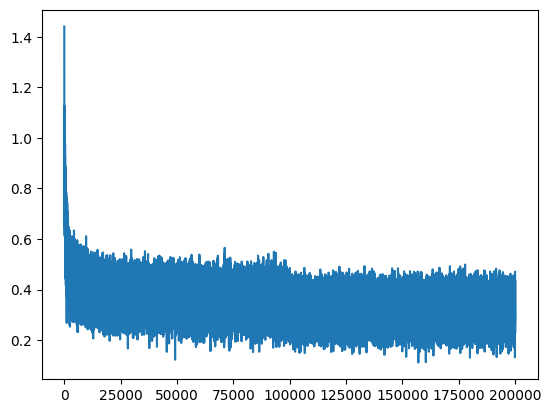

In [18]:
model(10,3,200,32)  
    
    

possibly over fitting?

model testing with dimR=10, context_length=3 and hide layer size=200:

loss on the final batch 1.7968454360961914

loss on the whole dev set 2.190011978149414

model testing with dimR=10, context_length=3 and hide layer size=200:
loss on the final batch 2.268420934677124
loss on the whole dev set 3.3591573238372803


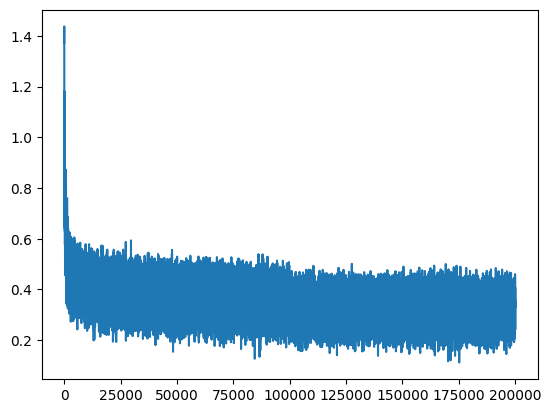

In [19]:
model(10,3,200,32, extra_links=True)  

Looks like overfitting

dredful 

model testing with dimR=10, context_length=3 and hide layer size=200:
loss on the final batch 2.150007486343384
loss on the whole dev set 2.1595375537872314


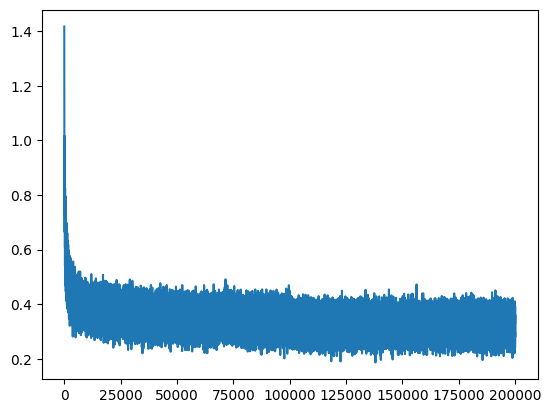

In [20]:
model(10,3,200,64)  

In [ ]:
model(10,3,400)

loss on the final batch 2.1111538410186768
loss on the whole dev set 2.170051336288452
